# Analyse d'image de gel d'agarose

---

Le [fichier](https://drive.google.com/file/d/19P0Mwxs3HwRywO4v1hLgFoRn8rrzvIjC/view?usp=sharing) représente l'image brute d'un gel d'agarose.

Créer un algorithme qui renvoie l'intensité des bandes pour chaque puit.  
On veillera à diminuer au maximum le nombre de paramètres libres.   
On veillera à détecter un maximum de bandes (même celles de faible intensité).  

---

## Plan d'analyse :
0. Pretraitement de l'image
    - Essaye d'application d'un filtre low-pass pour reduire le bruit
    - Essaye d'application d'un filtre high-pass pour detecter les frontières
1. Detection des coordonnées des puits
    - Identification des maximums pour chaque colonne
    - Utilisation du filtre binaire avec un seuil de 50% pour detecter les puits
    - Reduction du bruit
    - Detection des coordonnées des puits
2. Coupage de l'image en puits
    - Utilisation des coordonnées des puits pour couper l'image
3. Detection des coordonnées des bandes
    - Methode 1 : Detection des bandes separement pour chaique puit à partir de l'image decoupée
        - Identification des maximums pour chaque ligne
        - Identification d'un seuil pour detecter les bandes
        - Utilisation du filtre binaire avec un seuil identifié
        - Detection des coordonnées des bandes
    - Methode 2 : Detection des bandes pour l'ensemble des puits à partir de l'image entiere
        - Identification des maximums pour chaque ligne
        - Utilisation du filtre binaire avec un seuil de 64% pour detecter les bandes
        - Detection des coordonnées des bandes
4. Calcul de l'intensité des bandes pour chaque methode
    - Calcul de l'intensité d'arriere plan (definie comme la moyenne des pixels d'une tranche de l'image)
    - Calcul de l'intensité des bandes (definie comme la moyenne des pixels de la bande)
    - Calcul de l'intensité normalisée des bandes (definie comme l'intensité des bandes moins l'intensité d'arriere plan fois la largeur de la bande)
5. Comparaison des resultats des deux methodes

---

### Importation des librairies

In [1]:
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%reload_ext autoreload
%autoreload 2
sys.path.append('./scripts')
import tools

---

### Lecture de l'image

(244, 495)


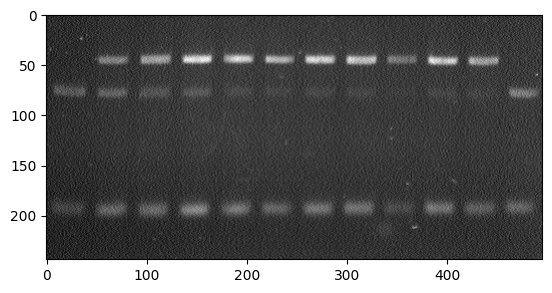

In [2]:
image = np.loadtxt("data/IM_GCCGCC_20220329.txt", delimiter='\t').astype(np.uint8)

print(image.shape)

plt.imshow(image, cmap='gray')
plt.show()

---

### Pretraitement de l'image

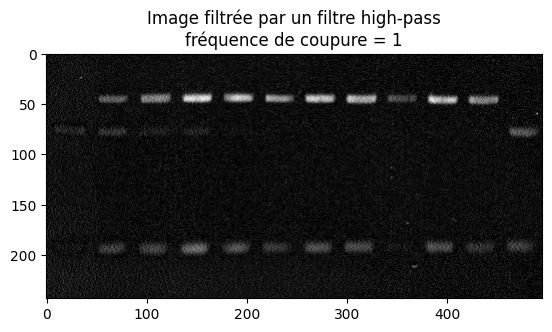

In [3]:
# Definir la fréquence de coupure
cutoff_freq = 1

# Appliquer le filtre
filtered_image = tools.image_high_pass_filter(image, cutoff_freq)

# Afficher l'image filtrée
plt.imshow(filtered_image, cmap='gray')
plt.title(f'Image filtrée par un filtre high-pass\nfréquence de coupure = {cutoff_freq}')
plt.show()

On peut voir que les bandes ont devenu plus visibles apres l'application du filtre high-pass. Cependant, on a perdu les bandes qui ont été pas très distinctes. Ainsi, vu que l'on veux detecter un maximum de bandes, on va utiliser l'image brute pour la suite de l'analyse. On va essayer d'appliquer un filtre low-pass pour reduire le bruit.

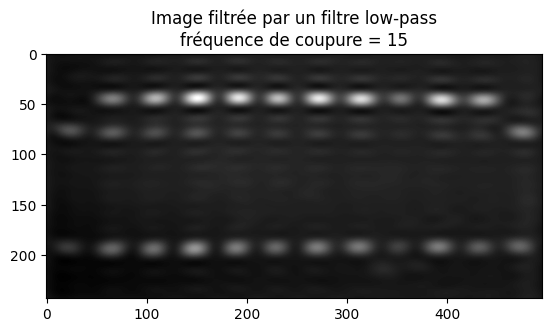

In [4]:
# Definir la fréquence pour le filtre low-pass
cutoff_freq = 15

# Appliquer le filtre
filtered_image = tools.image_low_pass_filter(image, cutoff_freq)

# Afficher l'image filtrée
plt.imshow(filtered_image, cmap='gray')
plt.title(f'Image filtrée par un filtre low-pass\nfréquence de coupure = {cutoff_freq}')
plt.show()


On voit que l'application du filtre low-pass a rendu l'image plus floue et il a ajouté des bandes supplementaires pas visibles avant. Cela nous posera des problemes lors de detection des bandes. Ainsi, on va utiliser l'image brute.

---

### Detection des coordonnées des puits

#### Methode 1 : Detection des bandes separement pour chaique puit à partir de l'image decoupée

La projection de l'image sur un axe est la somme des valeurs des pixels de l'image sur cet axe. Vu que notre image représente un gel d'agarose, la projection sur l'axe des x nous donne une idée sur les positions des puits. En effet, on s'attend avoir des pics au niveau des puits car la somme des pixels est plus élevée dans ces regions.  

On peut definir la projection pas comme la somme mais plutot comme le maximum des pixels de la colonne. Dans ce cas, on s'attend aussi avoir des pics au niveau des puits.  

Pour detecter les pics dans la projection, on va utiliser le filtre binaire avec un seuil de 50% pour detecter les pics. C'est à dire, on va considerer que les pics sont les valeurs superieurs à 50% de la valeur maximale de la projection.

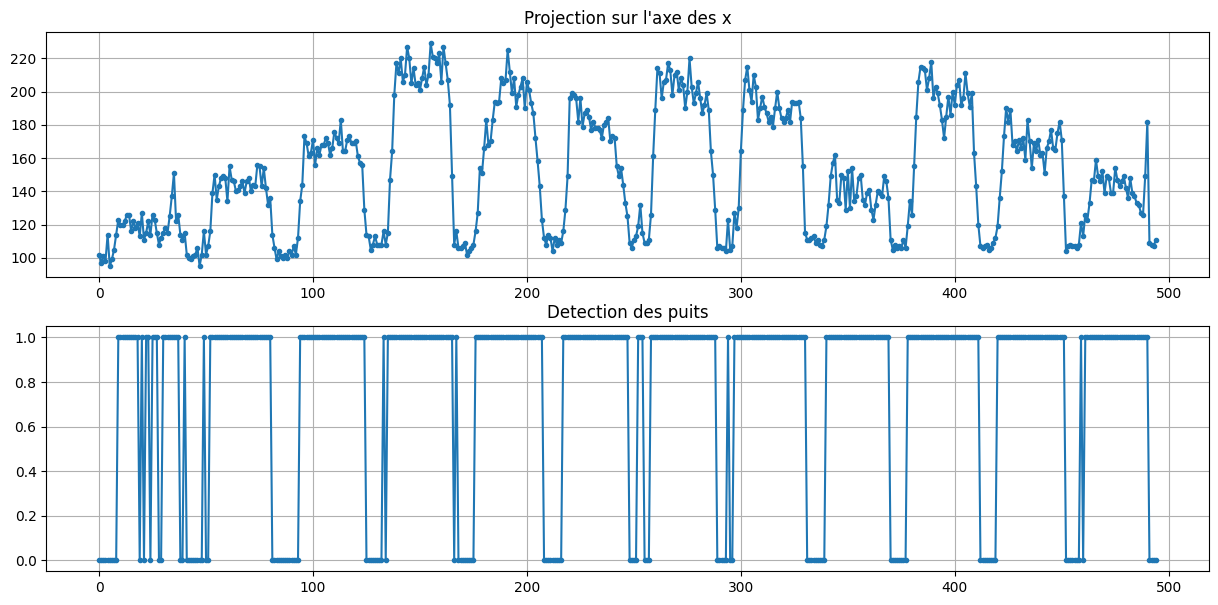

In [5]:
# Calculer la projection de l'image sur l'axe des x 
projection_x = image.max(axis=0)

# Definir un seuil pour filtrer les valeurs de la projection
filter_threshold = 0.5

# Filtrer les valeurs de la projection
filtered_x = projection_x > filter_threshold * np.max(projection_x)

# Afficher la projection
fig, ax = plt.subplots(2, 1, figsize=(15, 7))

ax[0].plot(projection_x, 'o-', markersize=3)
ax[0].set_title("Projection sur l'axe des x")
ax[0].grid(True)
ax[1].plot(filtered_x, 'o-', markersize=3)
ax[1].set_title("Detection des puits")
ax[1].grid(True)

plt.show()

On voit que cet approche nous a permi de detecter tous les 12 pics. Cependant, certaines pics ne sont pas continues. Il existe un bruit que l'on voudrais eliminer. Ainsi, on va utiliser l'approche suivante : des que l'on detecte un suite des False plus court que 3, on va les considerer comme des True. Cela nous a permi de detecter les 12 pics distincts.  

Une fois le bruit est eliminé, on peut detecter les coordonnées des puits comme les coordonnées des suites des True.

Les deux fonctions correspondantes sont `filter_noise` et `extract_band_coordinates` sont implementées dans le module `tools.py`.

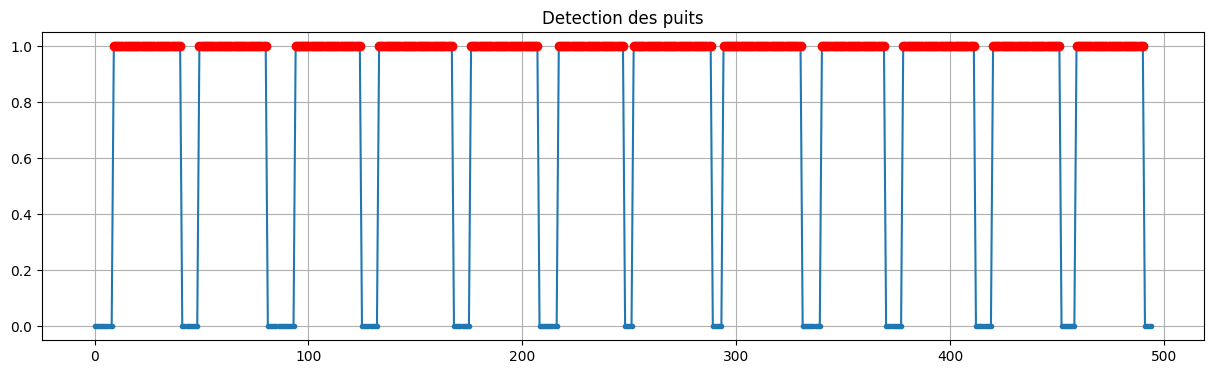

In [6]:
# Reduire le bruit 
filtered_x = tools.filter_noise(filtered_x)

# Extraire les coordonnees des bandes
band_coordinates = tools.extract_band_coordinates(filtered_x)

# Afficher la projection avec les bandes detectees
fig = plt.subplots(figsize=(15, 4))

plt.plot(filtered_x, 'o-', markersize=3)
plt.title("Detection des puits")
for pic in band_coordinates:
    start = pic[0]
    end = pic[1]
    for i in range(start, end + 1):
        plt.plot(i, filtered_x[i], 'ro')

plt.grid(True)        
plt.show()

On constate que les coordonnées des puits sont plutot bien detectées. On peut donc passer à la coupage de l'image en puits.

---

### Coupage de l'image en puits

Pour couper l'image en puits, on va utiliser les coordonnées des puits detectées avec des marges de 3 pixels.

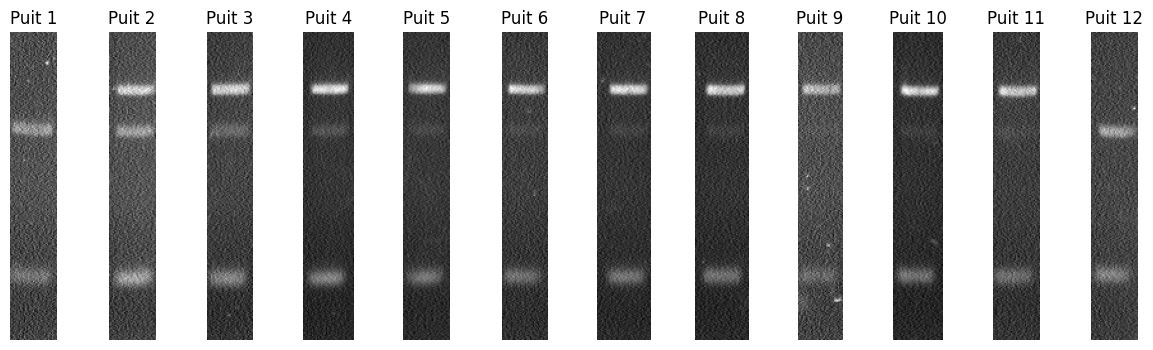

In [7]:
# Definir la marge 
marge = 3

# Extraire les images des puits
puit_slices = [image[:, x1-marge:x2+marge] for x1, x2 in band_coordinates]

# Afficher les images des puits
fig, axs = plt.subplots(1, len(puit_slices), figsize=(15, 4))
for i, puit_slice in enumerate(puit_slices):
    axs[i].imshow(puit_slice, cmap='gray')
    axs[i].set_title(f"Puit {i+1}")
    axs[i].axis('off')

On constate que l'image est plutot bien coupée en puits. On peut donc passer à la detection des coordonnées des bandes.

---

### Detection des coordonnées des bandes

Maintenant que l'on a les images des puits, on peut essayer de detecter les bandes pour chaque puit. On va essayer deux methodes, une pour detecter les bandes separement pour chaque puit et une autre pour detecter les bandes pour l'ensemble des puits à partir de l'image entiere. Pour cela on va utiliser la projection sur l'axe des y avec le même principe que la projection sur l'axe des x. Une difference est que l'on va definir un seuil qui va permettre de detecter les 3 bandes.

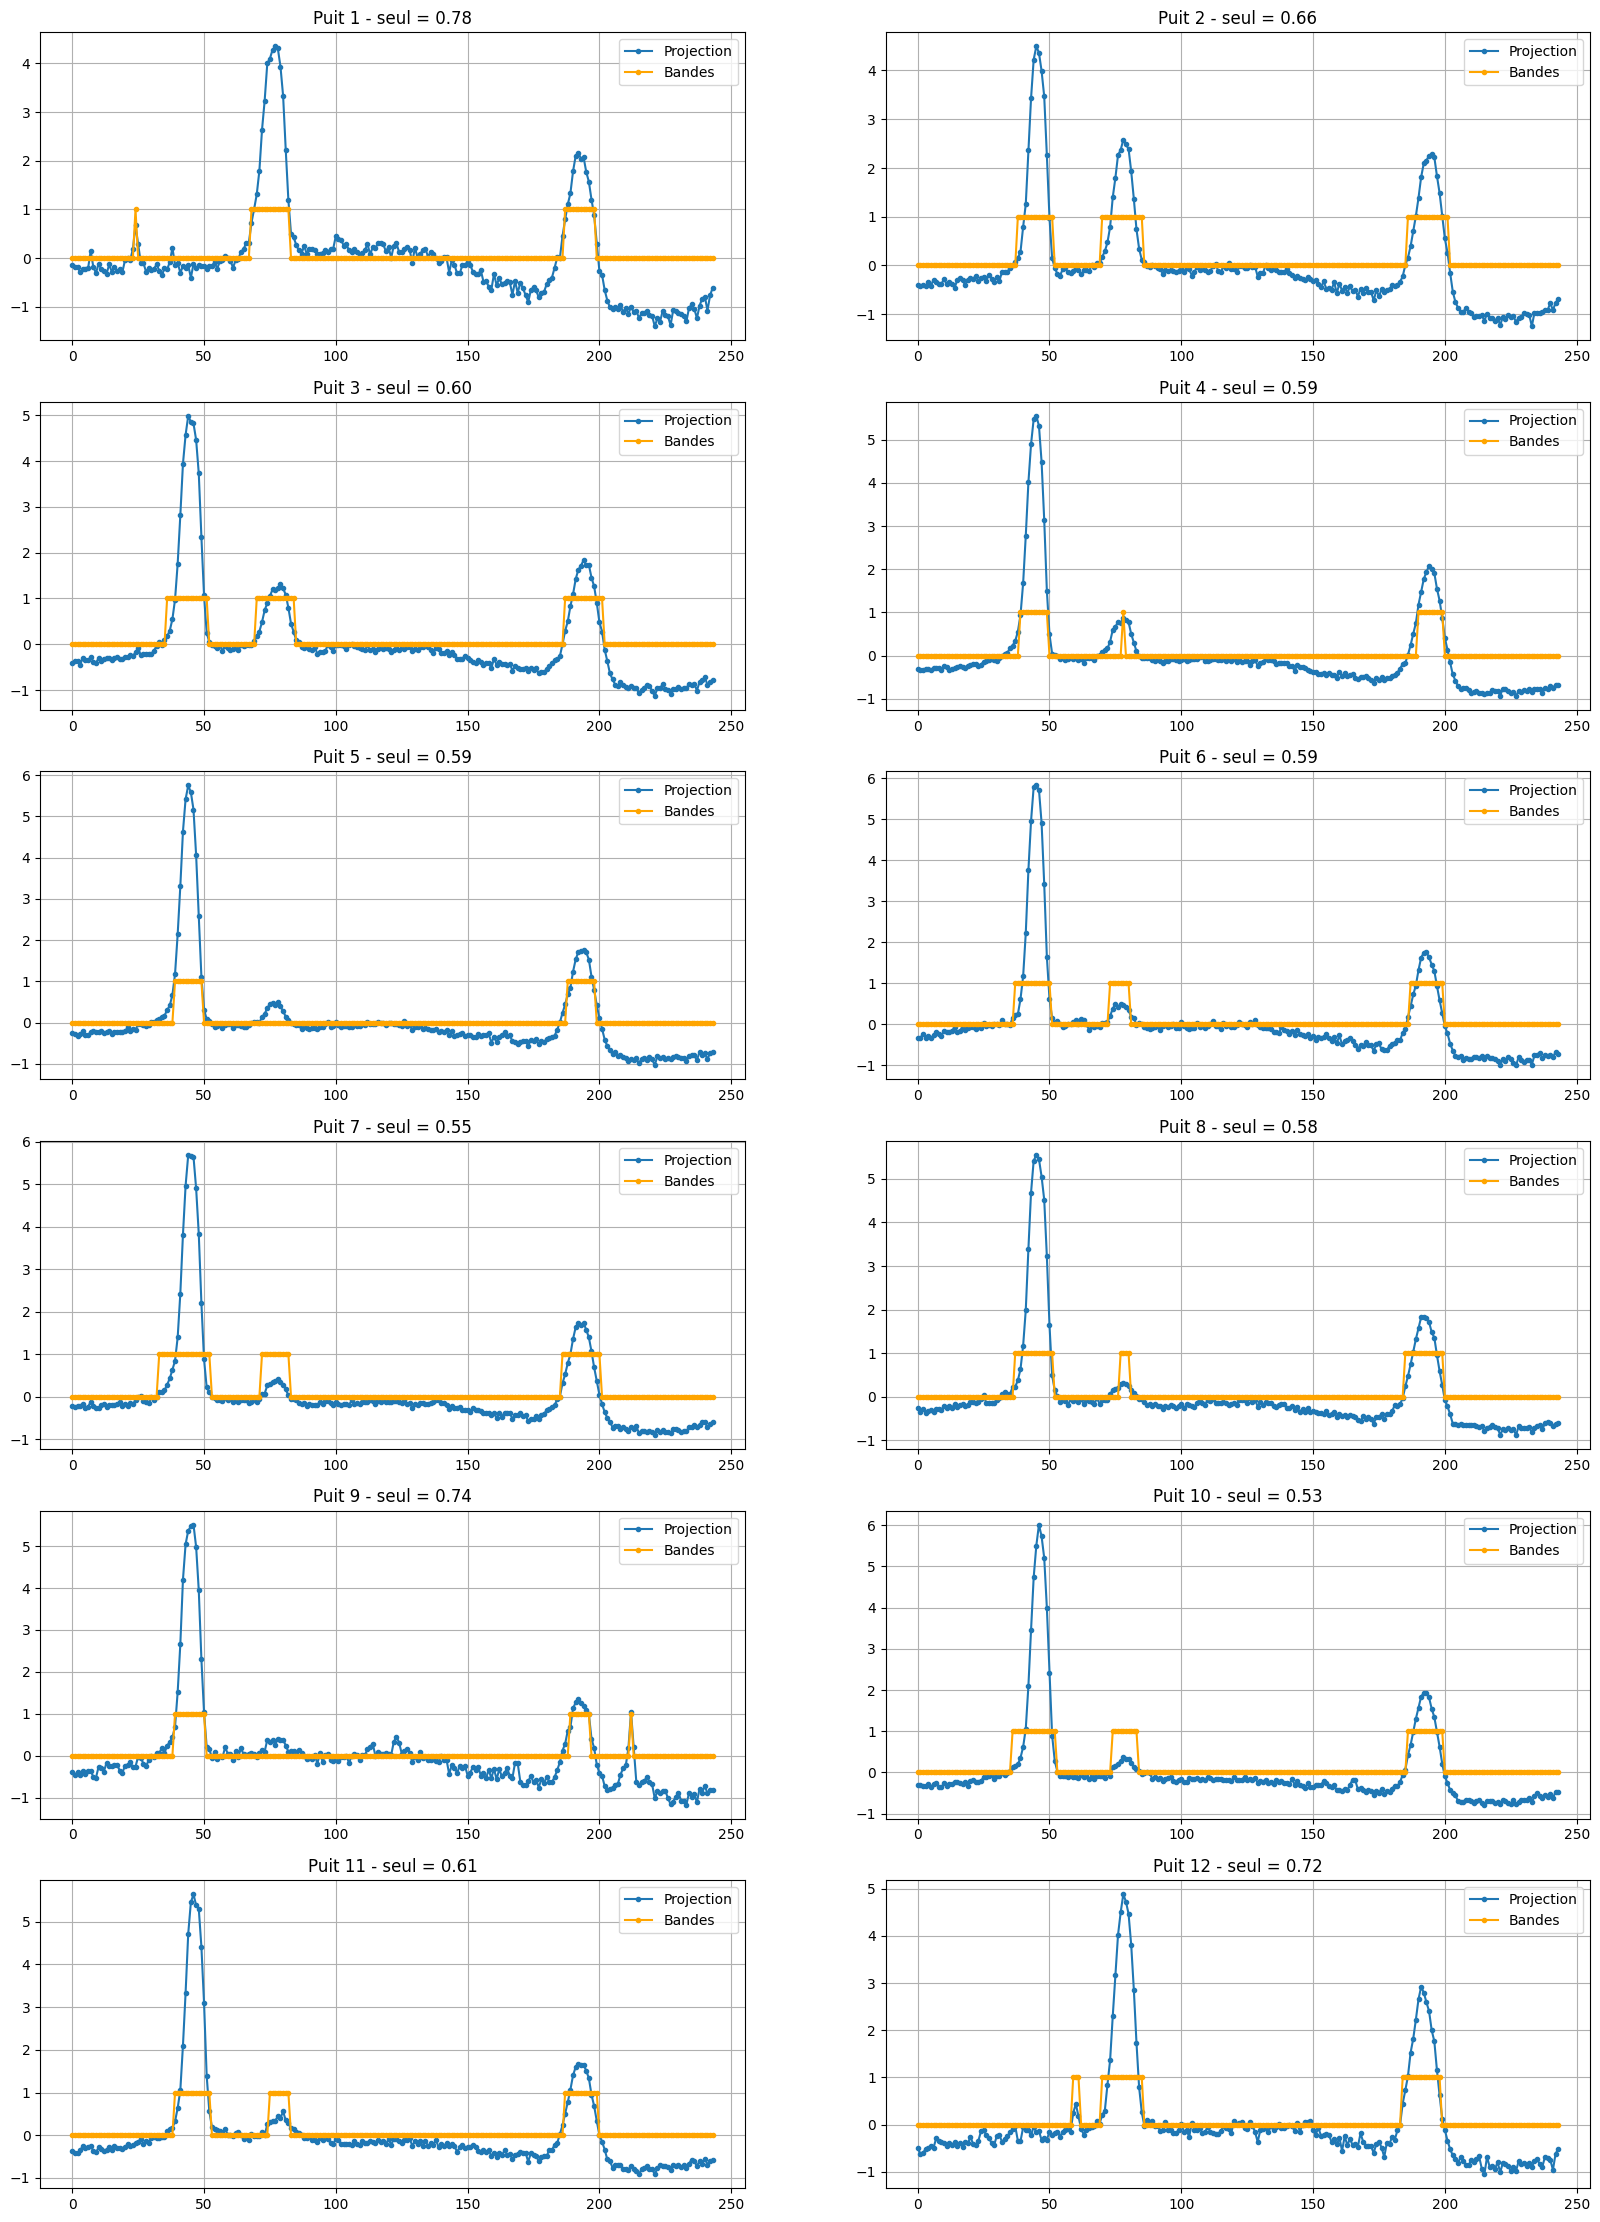

In [8]:
# Definir la liste des coordonnees des bandes
band_coordinates = []

plt.figure(figsize=(20, 28))

for i in range(len(puit_slices)):
    slice = puit_slices[i]

    # Calculer la projection de la tranche sur l'axe des y
    projection_y = slice.sum(axis=1)

    # Normaliser la projection
    norm_y = (projection_y - np.mean(projection_y)) / (np.std(projection_y))

    # Calculer le seuil pour avoir les 3 bandes
    current_threshold = 0.8
    while True:
        filtered_y = projection_y > current_threshold * np.max(projection_y)
        current_coordinates = tools.extract_band_coordinates(filtered_y)
        nb_bands = len(current_coordinates)
        if nb_bands == 3:
            threshold = current_threshold
            coordinates = current_coordinates
        if nb_bands > 3:
            break
        current_threshold -= 0.01
        
    band_coordinates.append(coordinates)
    filtered_y = projection_y > threshold * np.max(projection_y)

    # Afficher la projection
    plt.subplot(6, 2, i+1)
    plt.plot(norm_y, 'o-', markersize=3, label="Projection")
    plt.plot(filtered_y, 'o-', markersize=3, label="Bandes", color='orange')
    plt.title(f"Puit {i+1} - seul = {threshold:.2f}")
    plt.legend()
    plt.grid(True)
    

plt.show()

On remarque que pour la plupart des puits cette methode a reussi à detecter les bandes. Cependant, pour certains puits, on observe des artefacts :
- Pour le puit 1, on observe un pic supplementaire qui n'est pas une bande mais qui correspond à un point blanc dans l'image brute.
- Pour le puit 9, on detecte pas la bande de milieu, mais on detecte un point blanc en bas dans l'image brute.
- Pour le puit 11, on detecte la bande de milieu, mais pas très bien.
- Pour le puit 12, on detecte pas la bande d'haut, mais il y'en a pas dans l'image brute non plus. Mais on detecte un point blanc en haut dans l'image brute.

On constate donc que notre methode est assez sensible aux artefacts, mais il arrive quand même à detecter les bandes pour la plupart des puits. On peut maintenant les visualiser.

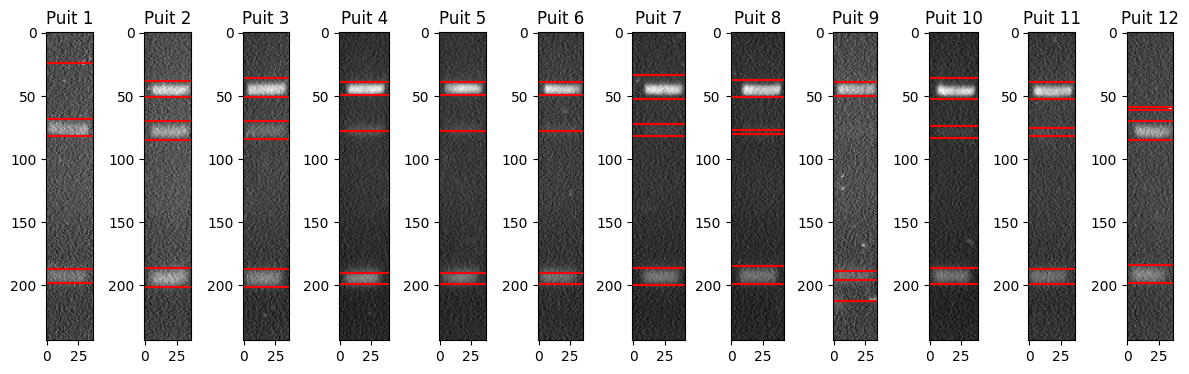

In [9]:
# Afficher les bandes detectees

fig, axs = plt.subplots(1, len(puit_slices), figsize=(15, 4))
for i, puit_slice in enumerate(puit_slices):

    axs[i].imshow(puit_slice, cmap='gray')
    for coord in band_coordinates[i]:
        start, end = coord
        axs[i].axhline(start, color='r')
        axs[i].axhline(end, color='r')
    axs[i].set_title(f"Puit {i+1}")
    #axs[i].axis('off')

---

### Calcul de l'intensité des bandes

In [10]:
for i, puit_slice in enumerate(puit_slices):
    
    print(f"Puit {i+1}")
    print(f"_____________________________")
    
    for j, coordinates in enumerate(band_coordinates[i]):
        start, end = coordinates
        
        print(f"Bande {j+1} ({start} - {end})", end=" ")
        
        reference_band = puit_slice[130:160, :]
        band = puit_slice[start-1:end+1, :]
        
        reference_intensity = reference_band.mean()
        band_intensity = band.mean()
        band_size = end - start + 1
        
        print(f"Intensité  : {(band_intensity - reference_intensity) * band_size:.2f}")
    print()


Puit 1
_____________________________
Bande 1 (24 - 24) Intensité  : 3.42
Bande 2 (68 - 82) Intensité  : 254.08
Bande 3 (187 - 198) Intensité  : 117.31

Puit 2
_____________________________
Bande 1 (38 - 51) Intensité  : 327.92
Bande 2 (70 - 85) Intensité  : 236.71
Bande 3 (186 - 201) Intensité  : 237.48

Puit 3
_____________________________
Bande 1 (36 - 51) Intensité  : 514.86
Bande 2 (70 - 84) Intensité  : 183.05
Bande 3 (187 - 201) Intensité  : 235.68

Puit 4
_____________________________
Bande 1 (39 - 49) Intensité  : 605.37
Bande 2 (78 - 78) Intensité  : 16.52
Bande 3 (190 - 199) Intensité  : 273.45

Puit 5
_____________________________
Bande 1 (39 - 49) Intensité  : 547.53
Bande 2 (78 - 78) Intensité  : 9.47
Bande 3 (190 - 199) Intensité  : 208.17

Puit 6
_____________________________
Bande 1 (39 - 49) Intensité  : 436.67
Bande 2 (78 - 78) Intensité  : 7.93
Bande 3 (190 - 199) Intensité  : 162.34

Puit 7
_____________________________
Bande 1 (33 - 52) Intensité  : 598.49
Bande 2 

---

#### Methode 2 : Detection des bandes pour l'ensemble des puits à partir de l'image entiere

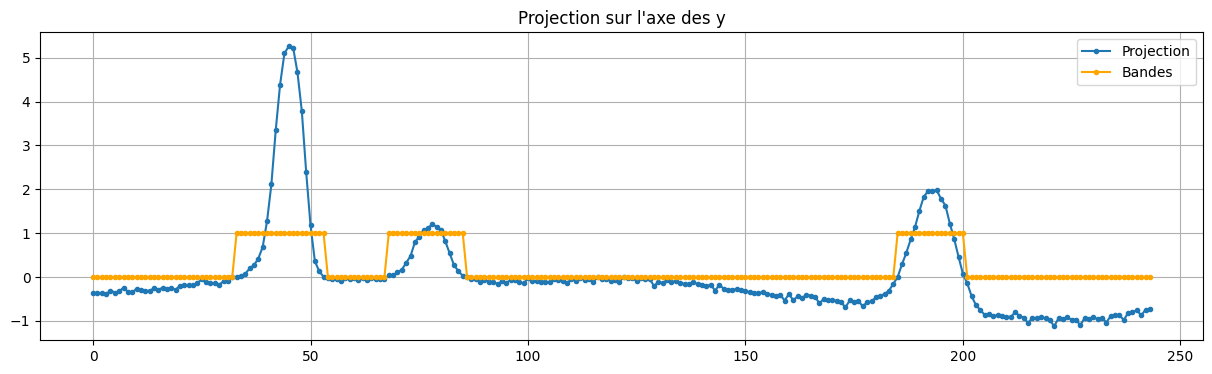

In [11]:
image = np.loadtxt("IM_GCCGCC_20220329.txt", delimiter='\t').astype(np.uint8)

# Calculer la projection de l'image sur l'axe des y
projection_y = image.sum(axis=1)

# Normaliser la projection
norm_y = (projection_y - np.mean(projection_y)) / (np.std(projection_y))

# Definir un seuil pour filtrer les valeurs de la projection
filter_threshold = -0.0006

# Filtrer les valeurs de la projection
filtered_y = norm_y > filter_threshold * np.max(norm_y)

# Extraire les coordonnees des bandes
band_coordinates = tools.extract_band_coordinates(filtered_y)

# Afficher la projection
plt.figure(figsize=(15, 4))

plt.plot(norm_y, 'o-', markersize=3, label="Projection")
plt.plot(filtered_y, 'o-', markersize=3, label="Bandes", color='orange')
plt.title("Projection sur l'axe des y")
plt.legend()
plt.grid(True)

plt.show()

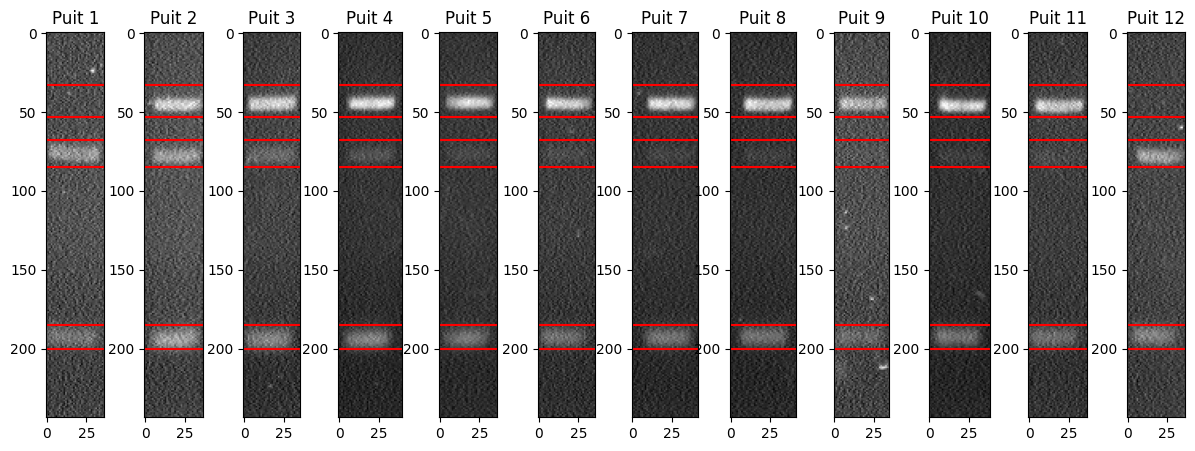

In [12]:
# Afficher les bandes detectees

fig, axs = plt.subplots(1, len(puit_slices), figsize=(15, 5))
for i, puit_slice in enumerate(puit_slices):

    axs[i].imshow(puit_slice, cmap='gray')
    for coord in band_coordinates:
        start, end = coord
        axs[i].axhline(start, color='r')
        axs[i].axhline(end, color='r')
    axs[i].set_title(f"Puit {i+1}")
    #axs[i].axis('off')

---

### Calcul de l'intensité des bandes

In [13]:
for i, puit_slice in enumerate(puit_slices):
    
    print(f"Puit {i+1}")
    print(f"_____________________________")
    
    for j, coordinates in enumerate(band_coordinates):
        start, end = coordinates
        
        print(f"Bande {j+1} ({start} - {end})", end=" ")
        
        reference_band = puit_slice[130:160, :]
        band = puit_slice[start-1:end+1, :]
        
        reference_intensity = reference_band.mean()
        band_intensity = band.mean()
        band_size = end - start + 1
        
        print(f"Intensité  : {(band_intensity - reference_intensity) * band_size:.2f}")
    print()


Puit 1
_____________________________
Bande 1 (33 - 53) Intensité  : -4.38
Bande 2 (68 - 85) Intensité  : 265.98
Bande 3 (185 - 200) Intensité  : 123.06

Puit 2
_____________________________
Bande 1 (33 - 53) Intensité  : 345.38
Bande 2 (68 - 85) Intensité  : 242.94
Bande 3 (185 - 200) Intensité  : 232.98

Puit 3
_____________________________
Bande 1 (33 - 53) Intensité  : 536.39
Bande 2 (68 - 85) Intensité  : 193.93
Bande 3 (185 - 200) Intensité  : 229.60

Puit 4
_____________________________
Bande 1 (33 - 53) Intensité  : 691.09
Bande 2 (68 - 85) Intensité  : 172.49
Bande 3 (185 - 200) Intensité  : 318.74

Puit 5
_____________________________
Bande 1 (33 - 53) Intensité  : 621.77
Bande 2 (68 - 85) Intensité  : 100.74
Bande 3 (185 - 200) Intensité  : 250.30

Puit 6
_____________________________
Bande 1 (33 - 53) Intensité  : 493.96
Bande 2 (68 - 85) Intensité  : 84.09
Bande 3 (185 - 200) Intensité  : 192.87

Puit 7
_____________________________
Bande 1 (33 - 53) Intensité  : 602.80
Ban

---

### Discussion des resultats

Le raisonement derriere la methode 1 est que l'on detecte les bandes pour chaque puit separement ce qui permet de les detecter plus precisement et surtout avec la vrai largeur. Vu que l'on defnit l'intensité en tennant compte de la largeur de la bande, on s'attend avoir des resultats plus precis. Cependant, cette methode est assez sensible aux artefacts, ce qui pose des problemes lors de detection des bandes.

Le raisonement derriere la methode 2 est que l'on detecte les bandes pour l'ensemble des puits à partir de l'image entiere ce qui permet de detecter les bandes pour tous les puits en meme temps. Cela nous permet de detecter les bandes pour les puits qui ont des artefacts. Cependant, cette methode est moins precise car on ne tient pas compte de la largeur des bandes et on assume qu'il y a forcement 3 bandes par puit. 

Vu que l'on normalise l'intensité des bandes par l'intensité d'arriere plan, on s'attend obtenir les intensités plus precis qui tient en compte les differences d'intensité d'arriere plan pour chaque puit. Cependant, on constate qu'il existent les intensités negatives. Cela est du au fait que l'intensité d'arriere plan est plus grande que l'intensité des bandes. Ainsi, on peut considerer que l'intensité d'arriere plan pourait etre calculer mieux.